# Anisotropy

See Olsthoorn, H2O (1982, Nr. 11, p261, 263-267) "Anisotroie, een verwaarloosd verschijnsel bij grondwatervraagstukken."

The idea is to show aniotropy in figure.

First some exercises, further down the real example.

This is ongoing work


@TO 20251126

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib import patches
from itertools import cycle
from scipy.special import exp1

## Using Affine2D()

from matplotlib.trasnforms import Affine2D

    . ax.transData            --- from virtual coordinates to normal data coordinates
    . ax.transAxes            --- from virtual coordinates to axes-relative (0 - 1) coordinates
    . ax.transFigure          --- from virtual coordinates to figure-relative (0 - 1)
    . ax.transDta.inverted()  --- from virtual coordinates to convert from display back to data

### Transform data coordinates to display (pixel) coordinates

xdata, ydata = 1.2, 0.7
xdisp, ydisp = ax.transData.transform((xdata, ydata))

### Transform diplay (pixel) coordinates back to data coordinates

xdata2, ydata2 = ax.transData.inverted().transform((xdisp, ydisp))

### Round trip

assert (xdata, ydata) == (xdata2, ydata2)

Affine2D().scale(sx, sy)
Affine2D().rotate(theta)
Affine2D().rotate_deg(deg)
Affine2D().shear(shx, shy)
Affine2D().skew_deg(shx, shy)
Affine2D().translate(tx, ty)

### Concatenate transforms using the dot

rotations, scaling, translation etc.

T = Affine2D().rotate(alpha).scale(sx, sy).translate(tx, ty)

### Use method transform to apply the transform to data coordinates in figure

ax.transData yields pixel coordinates of the screen, seldom interesting for the user.

T = T + ax.transData
xy_new = T.transform(xy_old)

In [3]:
# --- Affine2D has a 41 usable attributes
# [p for p in dir(Affine2D) if not p.startswith('_')]

In [4]:
# help(Affine2D().translate)
# help(Affine2D().transform)

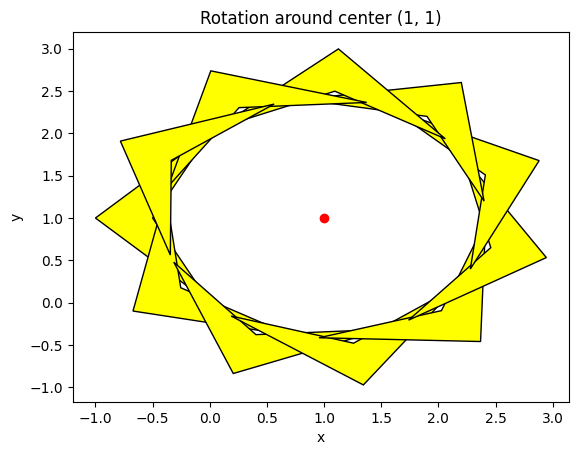

In [5]:
def shift(dx, dy):
    """Return an affine translation"""
    return Affine2D().translate(dx, dy)

def rotation_around_center(angle, center=(0, 0)):
    """Return an Affine2D rotation around an arbitrary point."""
    cx, cy = center
    return (Affine2D()
            .translate(-cx, -cy)
            .rotate_deg(angle)
            .translate(cx, cy))


fig, ax = plt.subplots()

xy = np.array([[0., 0.], [-1., 1.], [0, 2] ,[-0.5, 1] ,[0, 0]])
center = (1, 1)
ax.set(title=f"Rotation around center ({center[0]}, {center[1]})", xlabel='x', ylabel='y')
ax.plot(*center, 'ro')
for angle in np.linspace(0, 333, 11):
    rot = rotation_around_center(angle, center=center)
    p = patches.Polygon(xy, fc='yellow', ec='black')
    p.set_transform(rot + ax.transData)
    ax.add_patch(p)

ax.autoscale()

## Example of use of Affine2D

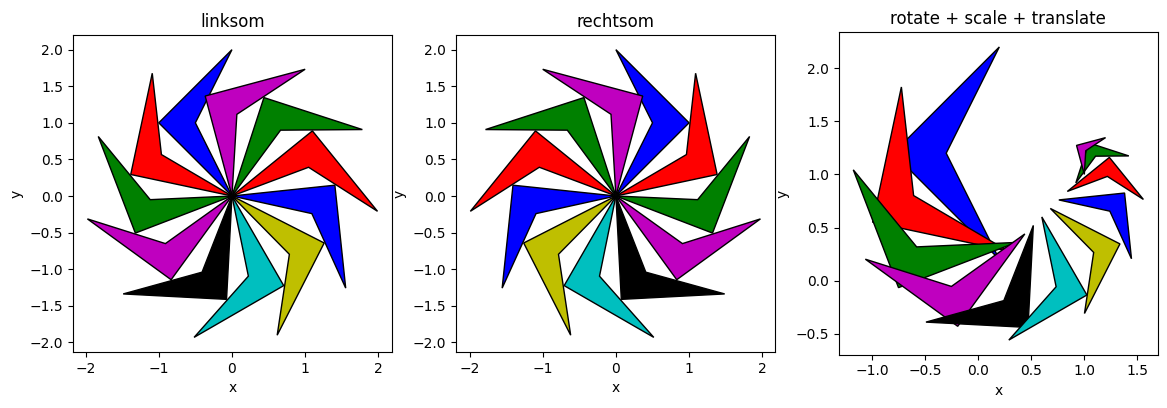

In [6]:
def update_datalim(patch, ax):
    """Update the ax.datalim for autoscaling."""
    path = patch.get_path()
    trans = patch.get_patch_transform()
    verts = trans.transform(path.vertices)
    ax.update_datalim(verts)

# --- shape (sikkel)
xyR = np.array([[0., 0.], [1., 1.], [0, 2] ,[0.5, 1] ,[0, 0]])
xyL = np.array([[0., 0.], [-1., 1.], [0, 2] ,[-0.5, 1] ,[0, 0]])

# --- show it
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(14, 7))

ax1.set(title='linksom',  xlabel='x', ylabel='y')
ax2.set(title='rechtsom', xlabel='x', ylabel='y')
ax3.set(title='rotate + scale + translate', xlabel='x', ylabel='y')

# ax1.plot(*xyL.T)
# ax2.plot(*xyR.T)
# ax3.plot(*xyL.T)

# --- rotate it
clrs = cycle('brgmkcy')
for alpha, s, t in zip(np.linspace(0, 330, 11), np.linspace(1, 0.2, 11), np.linspace(0.2, 1, 11)):
    clr = next(clrs)
    
    # --- rotate clockwise
    trL = Affine2D().rotate_deg(alpha)
    pL = patches.Polygon(xyL, fc=clr, ec='black')
    pL.set_transform(trL + ax1.transData)
    
    # --- rotate anti-clockwise
    trR = Affine2D().rotate_deg(-alpha)
    pR = patches.Polygon(xyR, fc=clr, ec='black')
    pR.set_transform(trR + ax2.transData)
    
    # --- rotate, scale and translate
    tr = Affine2D().rotate_deg(alpha).scale(s, s).translate(t, t)
    p = patches.Polygon(xyL, fc=clr, ec='black')
    p.set_transform(tr + ax3.transData)
    
    # --- update datalim of the axes
    update_datalim(pL, ax1)
    update_datalim(pR, ax2)
    update_datalim(p,  ax3)

    # --- add the patches
    ax1.add_patch(pL)
    ax2.add_patch(pR)
    ax3.add_patch(p)
        
# --- apply autoscale, without it the xlim and ylim are still 0-1
ax1.autoscale_view()
ax2.autoscale_view()
ax3.autoscale_view()
    
# --- keep axes the same
ax1.set_aspect(1.0)
ax2.set_aspect(1.0)
ax3.set_aspect(1.0)

fig.savefig(os.path.join(os.getcwd(), '../images', 'test_affine.png'))


# Code groundwater in the complex plane and affine coordinate transformations

In [7]:
np.isscalar(3 + 1j * 8)

True

In [130]:
def arrow(xy1, xy2, ax=None, transform=None, **kwargs):
    """
    Draw a proper arrow with optional affine transform.
    Keeps arrow head size stable and updates axes limits.
    """
    ax = ax or plt.gca()
    
    # complex support
    if np.isscalar(xy1):
        xy1  = z2xy(np.complex128(xy1))
    if np.isscalar(xy2):
        xy2 = z2xy(np.complex128(xy2))
    
    # Base data coords
    p0 = np.asarray(xy1)
    p1 = np.asarray(xy2)

    # --- Autoscale must use *transformed* coords
    if transform is not None:
        pts = transform.transform(np.vstack([p0, p1]))
    else:
        pts = np.vstack([p0, p1])

    ax.update_datalim(pts)
    ax.autoscale_view()

    # --- Annotation uses untransformed coords + explicit transform
    return ax.annotate(
        "",
        xy=p1,
        xytext=p0,
        arrowprops=dict(
            arrowstyle="-|>",
            shrinkA=0,
            shrinkB=0,
            linewidth=1.5,
            **kwargs
        ),
        transform=transform + ax.transData if transform is not None else ax.transData
    )


def point_to_line_vector(zp, z1, z2):
    """
    Compute vector from zp to line through z1 and z2 (complex numbers).
    Returns (v, F) where:
      v = vector from zp to its projection F on the line
      F = foot point on line
    """
    zp, z1, z2 = complex(zp), complex(z1), complex(z2)
    d = z2 - z1

    if d == 0:
        raise ValueError("z1 and z2 must be distinct points")

    # projection parameter t
    t = np.real((zp - z1) * np.conj(d)) / (abs(d)**2)

    # foot of perpendicular
    F = z1 + t * d

    # vector from zp to line
    v = F - zp
    return v, F


def om_fr_z(z, Q=None, L=None):
    return -1j * Q / np.pi * np.arcsin(2 * z / L + 0 * 1j)

def z_fr_om(om, Q=None, L=None):
    return L / 2 * np.sin(1j * om * np.pi / Q)
    
def make_complex(x=None, y=None):    
    X, Y = np.meshgrid(x, y)
    return X + 1j * Y


def trans_z(Z=None, tr=None):
    """Return transform of complex coordinates Z."""
    Z = np.atleast_1d(Z)
    shape = Z.shape
    xy = z2xy(Z.ravel())
    Z = xy2z(tr.transform(xy)).reshape(shape)  
    return Z if len(Z) > 1 else Z.item() 

def z2xy(z):
    """Convert complex numbers or arrays of complex numbers to arrays of (x, y) pairs.
    
    >>> z2xy(3 + 4j)
    array([3., 4.])

    >>> z2xy([1+2j, 3+4j])
    array([[1., 2.],
           [3., 4.]])

    >>> Z = np.array([[1+1j, 2+2j],[3+3j, 4+4j]])
    >>> z2xy(Z).shape
    (2, 2, 2)

    """
    z = np.asanyarray(z)          # accept lists, tuples, numpy arrays, scalars
    zr = np.real(z)
    zi = np.imag(z)
    xy = np.stack((zr, zi), axis=-1)
    return xy


def xy2z(xy):
    """Convert (x, y) pairs to complex numbers, preserving array shape."""
    xy = np.asanyarray(xy)
    if xy.shape[-1] != 2:
        raise ValueError("Last dimension must be length 2: (x, y)")
    return xy[..., 0] + 1j * xy[..., 1]


def plotz(z, fmt, *, ax=None, **kwargs):    
    """Plot complex coordinates.
    Parameters
    ----------
    z: complex number of np.ndarray of complex numbers
        points to plot
    fmt: None | linestyle-color format as in plt
        the format
    ax: None | Axes
        the axes to plot onto
    kwars: key parameters
        passed on to plt.plot(... **kwargs)
    """
    if ax is None:
        ax = plt.gca()
    if fmt is None:
        ax.plot(z.real, z.imag, **kwargs)
    else:
        ax.plot(z.real, z.imag, fmt, **kwargs)


## Linesink of constant head and given total discharge

In [9]:
        
def get_pq(z1, z2):
    """Return p and q which map z1 and z2 to -L/2 and L/2."""
    L = np.abs(z1 - z2)
    D = z1 - z2
    p = -L / D
    q = 0.5 * (z1 + z2) * L / D
    return p, q
    
def linesink(Z, z1=None, z2=None, Q=None):
    """Return omega cause by line sink between z1 and z2 injecting Q.
        
    Parameters
    ----------
    Z: coordinates (complex number)
        Locations where Omega is to be computed.
    z1: complex number
        location of one end of the line sink
    z2: complex number
        location of the other end of the line sink.
    Q: real number
        total injection/extraction of the line sink

    Return
    ------
        Omega: comples numbers
            Phi + i Psi at points Z. The reference Omega is
            the mean of that at the ponts along the linesink.
    """
    L = np.abs(z1 - z2)
    p, q = get_pq(z1, z2)
    Z1 = Z * p + q
    w = om_fr_z(Z1, Q=Q / 2, L=L)
    # -- Prevent jump across Phi=0
    w.real = np.abs(w.real)
    return w

def wellseries(Z, z1, z2, Q, N=20):
    """Return drawdown of line sink simulated by a well series.
    
    Parameters
    ----------
    Z: coordinates (complex number)
        Locations where Omega is to be computed.
    z1: complex number
        location of one end of the line sink
    z2: complex number
        location of the other end of the line sink.
    Q: real number
        total injection/extraction of the line sink
    N: int
        Number of well to divide de line sink into.

    Return
    ------
        Omega: comples numbers
            Phi + i Psi at points Z. The reference Omega is
            the mean of that at the ponts along the linesink.
        Zw: complex array
            Well locations
        Zp: complex numbers
            locations along linesink between wells of which the average head
            is used as reference head.
    """
    L = z2 - z1
    # --- points along the line sink
    fp = np.linspace(0, 1, N + 1)
    fw = 0.5 * (fp[:-1] + fp[1:])
    
    Zw = z1 + fw * L
    Zp = z1 + fp  * L
    
    # --- drawdown at point due to wells a long line sink trajectory
    s  = np.zeros_like(Z,  dtype=np.complex128)
    sp = np.zeros_like(Zp, dtype=np.complex128)    
    for zw in Zw.T:
        s  += Q / (2 * N * np.pi) * np.log(Z  - zw)
        sp += Q / (2 * N * np.pi) * np.log(Zp - zw)
    # --- take the mean along the line sink as reference head    
    s -= np.mean(sp)    
    return s, Zw, Zp



## Example working towards anisotropy

Anisotropic case in 2D of a well near a canal, where the main conductivity axes make an angle of 40 deg with the map axes. The first image is the map, the second shows the map rotated to align with the horizontal and vertical axes (new map, say).The third image shows the scaling such that the conductivities become the same in both direction and the problem will be isotropic. The coordinates of the mirror well are computed to place this mirror well. The drawdown by well and  mirror well are computed on a grid in the istropic map. Then the contours of the drawdown are computed. Back-transformation of uses the coordinates of the contours, obtained from Cs.get_paths(). It also uses their level form Cs.levels and their edgecolors form cs.edgecolor or cs.ec. Transforms these back to the seond and then to the first image and plots them using the same colors as the original isotropic contour lines in image #3.

In [115]:
print(k1_, k2_)
print(np.dot(z2xy(k1_), z2xy(k2_)))
tr = rotate_aniso

print(z_arrow + trans_z(k1_, tr), z_arrow + trans_z(k2_, tr))


(15.32088886237956+12.855752193730785j) (-38.56725658119235+45.96266658713868j)
0.0
(19.999999999999996+200j) 260j


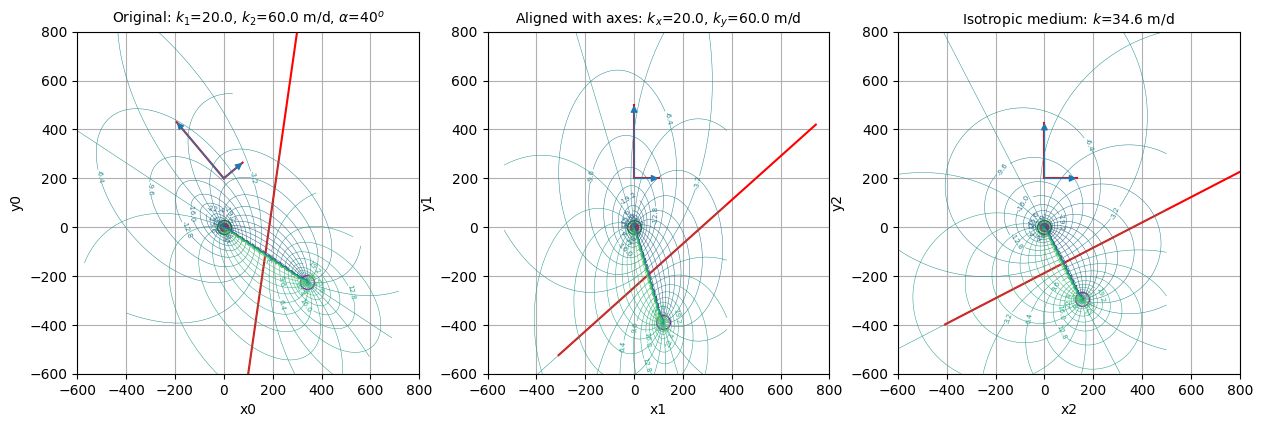

In [131]:
well = 0 + 1j * 0
alpha_aniso_deg = 40
k1, k2 = 20., 60.
Q, D, rwell = 2400., 30., 0.25
k = np.sqrt(k1 * k2)
zw = well
z_arrow = 1j * 200
shore = np.array([100 - 1j * 600,
                   300 + 1j * 800])

# --- define arrows lenghts do denote the axes direction
k1_ = 5 * xy2z(Affine2D().rotate_deg(alpha_aniso_deg).transform(z2xy(     k1)))
k2_ = 5 * xy2z(Affine2D().rotate_deg(alpha_aniso_deg).transform(z2xy(1j * k2)))

rotate_aniso = Affine2D().rotate_deg(-alpha_aniso_deg)
scale = Affine2D().scale(np.sqrt(k / k1), np.sqrt(k /k2))

# --- Transformations ---
tr0 = Affine2D()
tr1 = tr0 + rotate_aniso
tr2 = tr1 + scale

trs = [tr0, tr1, tr2]

# --- plotting
titles =[fr"Original: $k_1$={k1}, $k_2$={k2} m/d, $\alpha$={alpha}$^o$",
         fr"Aligned with axes: $k_x$={k1}, $k_y$={k2} m/d",
        fr"Isotropic medium: $k$={k:.1f} m/d"]

# --- Plot three consequtive axes to show original, rotated and stretched situations
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

# --- Loop over the three axes concatenating rotation and scaling using three sets of parameters
for i, (ax, tr, title) in enumerate(zip(axs.ravel(), trs, titles)):
            
    ax.set_title(title,    fontsize=10)
    ax.set_xlabel(f"x{i}", fontsize=10)
    ax.set_ylabel(f"y{i}", fontsize=10)
    
    ax.grid(True)

    # --- plot the well and the shore
    plotz(trans_z(well,  tr),'ro', ax=ax)
    plotz(trans_z(shore, tr), 'r-', ax=ax)
    
    plotz(np.array([z_arrow, z_arrow + trans_z(k1_, tr)], dtype=np.complex128), 'r-', ax=ax)
    plotz(np.array([z_arrow, z_arrow + trans_z(k2_, tr)], dtype=np.complex128), 'r-', ax=ax)

        
    # --- The axes arrows without ax.transData
    # if tr == trs[-1]:
    #     arrow(z_arrow,      k, ax=ax, transform=None, color="C0", lw=1)
    #     arrow(z_arrow, 1j * k, ax=ax, transform=None, color="C0", lw=1)
    # else:        
    arrow(z_arrow, z_arrow + trans_z(k1_, tr), ax=ax, transform=None, color="C0", lw=1)
    arrow(z_arrow, z_arrow + trans_z(k2_, tr), ax=ax, transform=None, color="C0", lw=1)
            
    ax.set_aspect(1.)
    ax.set_xlim(-600, 800)
    ax.set_ylim(-600, 800)

# --- Point perpendicular to the shore line in the isotropic situation
zw_iso     = trans_z(well,  tr)
zshore_iso = trans_z(shore, tr)

d, F = point_to_line_vector(zw_iso, zshore_iso[0], zshore_iso[1])

# --- Plot the line perpendicular to the coast
plotz(np.array([zw, zw + 2 * d]), 'g', ax=ax, lw=0.5)

# --- In the isotropic axes construct the drawdown and the contour lines
zw_mirror_iso = zw_iso + 2 * d

# --- Points to compute the drawdown
Ziso = make_complex(np.linspace(-700, 500, 121), np.linspace(-600, 800, 141))

# --- Distance from these grid points to the wells
r1 = Ziso - zw_iso;        r1[np.abs(r1) < rwell] = rwell
r2 = Ziso - zw_mirror_iso; r2[np.abs(r2) < rwell] = rwell

# --- The drawdown
Omega = Q / (2 * np.pi * D) * np.log(r1 / r2)
# s = Q / (2 * np.pi * kD) * np.log(r2 / r1)

tr0 = Affine2D()
tr1 = tr0 + scale.inverted()
tr2 = tr1 + rotate_aniso.inverted()

trs = [tr0, tr1, tr2]

# --- Contour the drawdown
levels = np.linspace(-1, 1, 51) * Q / D

for ax, tr in zip(axs[::-1], trs):
    
    Z = trans_z(Ziso, tr)
    zw        = trans_z(zw_iso, tr)
    zw_mirror = trans_z(zw_mirror_iso, tr)
    
    # --- plot well and mirror well
    plotz(zw_iso,    'go', ax=ax, ms=10, mfc='none')
    plotz(zw_mirror, 'mo', ax=ax, ms=10, mfc='none')
    
    Cs1 = ax.contour(Z.real, Z.imag, Omega.real, levels=levels, linewidths=0.35)
    Cs2 = ax.contour(Z.real, Z.imag, Omega.imag, levels=levels, linewidths=0.35)

    ax.clabel(Cs1, levels=Cs1.levels, fmt='%.1f', fontsize=5)
    # ax.clabel(Cs2, levels=Cs2.levels, fmt='%.1f', fontsize=5) # [np.abs(Cs2.levels) > 20]


os.path.isdir(os.path.join(os.getcwd(), 'images'))
fig.savefig(os.path.join(os.getcwd(), '../images', 'anisotropy.png'))

# Voorbeeld 2

Lijnsegment met vaste totale flow $Q$ en specifieke flux $Q / L$.

We beginnen met $\Omega$, want die kennen we van te voren in, $\Psi$ van $-Q/2$ tot $+Q/2$ hoirzontal, imaginaire as. En $\Phi$ $0\to Q$ reele as.

Schalen naar verticale Psi lijnen tussen -\pi/2 en +door eerst roteren en dan delen door Q en vermenigvuldigen met $\pi$ zodat de lijn Omega = $-i Q/2$ -- $i Q/2$ tussen -\pi/2 en $+/pi/2$ komt te liggen.

$$z = \frac L 2 \sin(i \Omega \pi / Q)$$

$$\Omega = - i \frac Q \pi \arcsin\left(2 \frac z L\right)$$

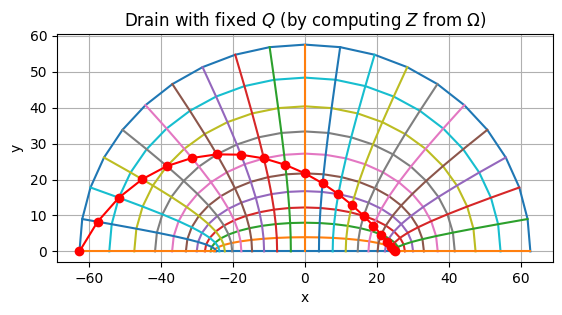

In [11]:
## Lijnelement met vaste q erlangs

# Oplossing via complex transformatie
L = 50.
Q = 10

psi = Q / 2 * np.linspace(-1, 1, 21)
phi = Q * np.linspace(0, 0.5, 11)
Phi, Psi = np.meshgrid(phi, psi)
Omega = Phi + 1j * Psi

Z = np.sin(1j * Omega * np.pi / Q) / 2 * L

fig, ax = plt.subplots()
ax.set(title=r"Drain with fixed $Q$ (by computing $Z$ from $\Omega$)", xlabel='x', ylabel='y')
ax.plot(Z.real, Z.imag)
ax.plot(Z.real.T, Z.imag.T)
ax.grid(True)
ax.set_aspect(1.0)

# --- Specfy values of Omega and show where these points lie in the z-plane
O = np.linspace(0, 0.5 * Q, 21) + 1j * np.linspace(-0.5 * Q, 0.5 * Q, 21)
z = z_fr_om(O, Q=Q, L=L)
ax.plot(z.real, z.imag, 'ro-', label='points')

## A linesink through points $z_1$ and $z_2$

We have the basic linesink between $z=\pm L/2$. What we do now is the  project the ends of the linsink ($z_1$ and $z_2$) to those point of the basic  line sink. For that the $\Omega$ is computed. This $\Omega$ is then used to contour at the orignal Z values (untransformed).

Notice that $\Omega = \Phi + i \Psi$ where the potential $\Phi = k \phi$ with $\phi$ the head.

The linesink is compared with a replacement using N small wells on a row with the same total discharge.

Notice, the head in the line of constant head is constant, whereas in the replacement it is not.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


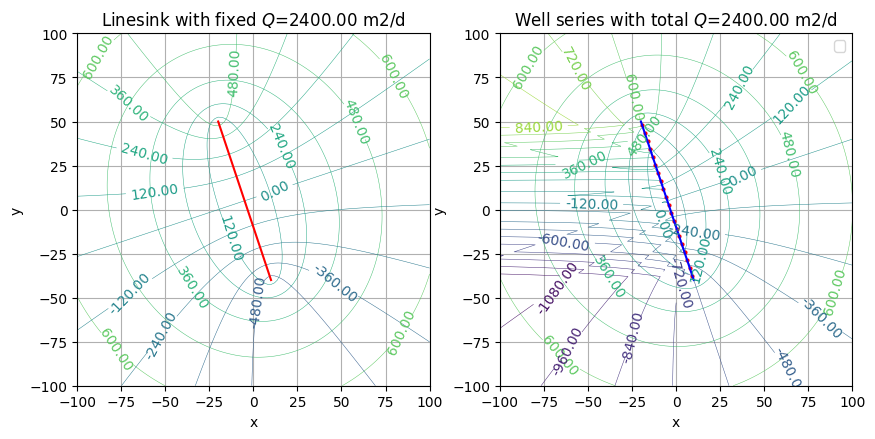

In [144]:
L = 50
Z = make_complex(x=np.linspace(-2 * L, 2 * L, 101),
            y=np.linspace(-2 * L, 2 * L, 101))

z1 = -20 + 1j * 50
z2 =  10 - 1j * 40
w1 = linesink(  Z=Z, z1=z1, z2=z2, Q=Q)
w2 = wellseries(Z=Z, z1=z1, z2=z2, Q=Q)

levels=np.linspace(-Q/2, Q/2, 21)

titles = [fr"Linesink with fixed $Q$={Q:.2f} m2/d",
          fr"Well series with total $Q$={Q:.2f} m2/d",
]
funcs = [linesink, wellseries]
          
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
for ax, title, func in zip(axs, titles, funcs):
    
    w = func(Z=Z, z1=z1, z2=z2, Q=Q)

    if isinstance(w, tuple):
        w, zw, zp = w
    else:
        zw, zp = None, None

    ax.set(title=title, xlabel='x', ylabel='y')

    Cs = ax.contour(Z.real, Z.imag, w.real, linewidths=0.35, levels=levels)
    ax.clabel(Cs, levels=Cs.levels, fmt='%.2f')

    Cs = ax.contour(Z.real, Z.imag, w.imag, linewidths=0.35, levels=levels)
    ax.clabel(Cs, levels=Cs.levels, fmt='%.2f')
    
    if zw is not None:
        ax.plot(zw.real, zw.imag, 'ro', ms=2)    
        ax.plot(zp.real, zp.imag, 'b', ms=2)
    else:        
        ax.plot([z1.real, z2.real], [z1.imag, z2.imag], 'r', label='linesink')
    ax.grid(True)
    ax.set_aspect(1)
ax.legend()

# Anisotropy with linesink


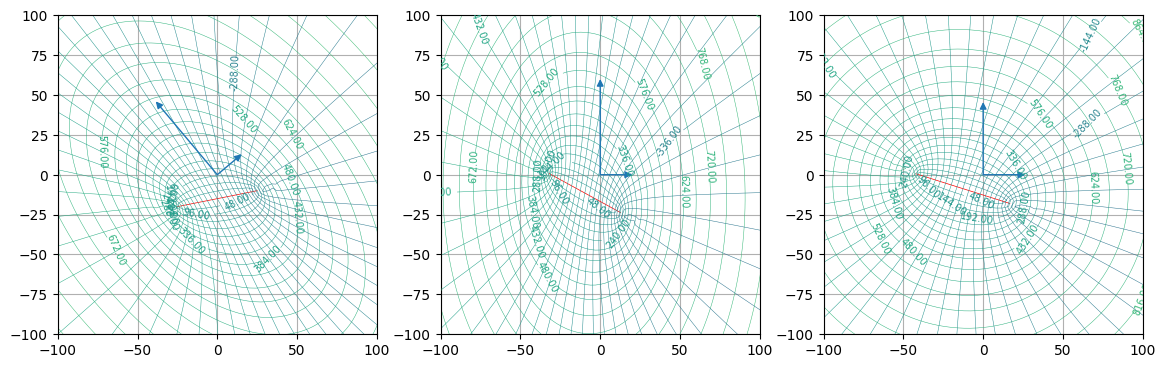

In [150]:
# --- anisotropy conductivity data
k1, k2 = 20., 60.
kx, ky = k1, k2
k = np.sqrt(k1 * k2)
alpha = 40
z_arrow = 0 + 1j * 0

Q = 2400.
levels = np.linspace(-1, 1, 101) * Q

# --- Orignal anisotropy indicating arrows, angle alpha
k1_ = xy2z(Affine2D().rotate_deg(alpha).transform(z2xy(     k1)))
k2_ = xy2z(Affine2D().rotate_deg(alpha).transform(z2xy(1j * k2)))

# --- transforms
rotate = Affine2D().rotate_deg(-alpha)
scale  = Affine2D().scale(np.sqrt(k / kx), np.sqrt(k / ky))

tr0 = Affine2D()
tr1 = tr0 + rotate
tr2 = tr1 + scale

trs = [tr0, tr1, tr2]

# --- position the linesink by its end points
z1_base = -25 - 1j * 20
z2_base = +25 - 1j * 10

p1_base = z1_base.real, z1_base.imag
p2_base = z2_base.real, z2_base.imag

lsink_base = np.array([p1_base, p2_base])

# --- Go over the figure and plot arrows and position of line sink
fig, axs = plt.subplots(1, 3, figsize=(14, 7))
for ia, (ax, tr) in enumerate(zip(axs, trs)):    
    
    # --- The axes arrows without ax.transData
    arrow(z_arrow, z_arrow + trans_z(k1_, tr), ax=ax, transform=None, color="C0", lw=1)
    arrow(z_arrow, z_arrow + trans_z(k2_, tr), ax=ax, transform=None, color="C0", lw=1)

    # --- Plot the linesink
    lsink  = tr.transform(lsink_base)       
    ax.plot(*lsink.T, 'r-', lw=0.5)

    # --- rounding off    
    ax.set_aspect(1.0)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    
# === Now backwards

# --- in the isotropic medium compute the Omega
tr = trs[-1]
ax = axs[-1]

# --- z coordinates in original anisotropy medium
Z_base = make_complex(np.linspace(-200, 200, 101), np.linspace(-200, 200, 101))

omega = linesink(Z=Z_base, z1=trans_z(z1_base, tr), z2=trans_z(z2_base, tr), Q=Q)
# omega = wellseries(Z_base, z1=trans_z(z1_base, tr), z2=trans_z(z2_base, tr), Q=Q)

if isinstance(omega, tuple):
    omega, zw, zp = omega
else:
    zw = None
    zp = None

# --- backwards transfrom starting in the isotropic medium
trs = [Affine2D(),
       scale.inverted(),
       scale.inverted() + rotate.inverted()]

# --- contour Omega using the coordinates of the different windows
for ax, tr in zip(axs[::-1], trs):
    Z = trans_z(Z_base, tr)
    # plotz(Z, '.r', ax=ax, ms=2)

    Cs1 = ax.contour(Z.real, Z.imag, omega.real, linewidths=0.35, levels=levels)
    ax.clabel(Cs1, levels=Cs1.levels, fmt='%.2f', fontsize='x-small')

    Cs2 = ax.contour(Z.real, Z.imag, omega.imag, linewidths=0.35, levels=levels)
    ax.clabel(Cs2, levels=Cs2.levels, fmt='%.2f', fontsize='x-small')
    
    ax.grid(True)
    ax.set_aspect(1)
    

fig.savefig(os.path.join(os.getcwd(), '../images', 'anisotropy_linsink.png'))

In [146]:
Q

2400.0

## Bruggeman (1999, 316.41)

Groundwater flow between a well with discharge Q and two straight semi-infinite surface water boundaries with entrrance resistance w, making an angle $\alpha\pi$ with eachother $0 \le \alpha \le 2$.
$$
\Omega = \frac Q {2 \pi} \left[
    \ln \left(   \frac{z^{1/\alpha}-\overline{z}_0^{1/\alpha}}{z^{1/\alpha} - z_0^{1/\alpha}}\right) + 
    2 \exp\left( \frac{z^{1/\alpha}-\overline{z}_0^{1/\alpha}}{i K w} \right)
    E_1 \left(   \frac{z^{1/\alpha}-\overline{z}_0^{1/\alpha}}{i K w}\right)
    \right]
$$

$$z = x + i y=r e^{-\theta};\;z_0 = x_0 + i y_0=r_0 e^{i \theta_0};\;\overline{z}_0 = x_0 - iy_0 = r_0e^{-i\theta_0}
$$
$$
E_1(z) = \int_z^\infty \frac 1 t e^{-t} dt=\int_1^\infty \frac 1 t e^{-z t} dt
$$

In [128]:
def b316_41(Z, z0=None, z1=None, slope_deg=None, Q_D=None, k=None, w=0, alpha_deg=180., rwell=0.25):
    """Return Omega for a well next to a shore with resistance.
    
    Parameters
    ----------
    Z : complex point or array of complex points (complex numbers)
        Locations for which to compute Omega
    z0: complex point
        location of the well
    z1: complex point
        shore passes through z1
    slope_deg: real
        direction of shore with respect to the x-axes (degrees)
    Q_D: float
        well discharge divided by aquifer thickness [m2/d]
    k: float
        hydraulic conductivity [m/d]
    w: float
        entry resistance of shore [d]
    alpha_deg: float
        angle that the shore left of z1 makes with shore right of z1
        It's slope will be slope)deg + alpha_deg
    rwell: float
        radius of well
    """
    
    # --- first rotate and translate the shore so that it falls on the x-axs and z1 is in (0, 0)
    
    tr = Affine2D().rotate_deg(-slope_deg).translate( 0 -z1.real, 0 - z1.imag)
    Z=  np.atleast_2d(Z)
    
    # --- handle point inside wells
    Z[np.abs(Z - z0) < 0.25] += rwell

    # --- transform the coordinates
    Z  = trans_z(Z,  tr)
    z0 = trans_z(z0, tr)
    z1 = trans_z(z1, tr)
        
    # --- compute Omega in the standard manner for shore for x > 0 falls on the x-axis
    a = alpha_deg / 180.
    zz0c = Z ** (1 / a) - z0.conjugate() ** (1 / a)
    zz0  = Z ** (1 / a) - z0             ** (1 / a)
    
    if w == 0:
        F = np.log(zz0c  / zz0)
    else:
        F = np.log(zz0c  / zz0) + 2 * np.exp(zz0c / (1j * k * w)) * exp1(zz0c / (1j * k * w))
    return Q_D  / (2 * np.pi) * F

Q/D=1.0, w=0, k=1.0
Q/D=1.0, w=5.0, k=1.0


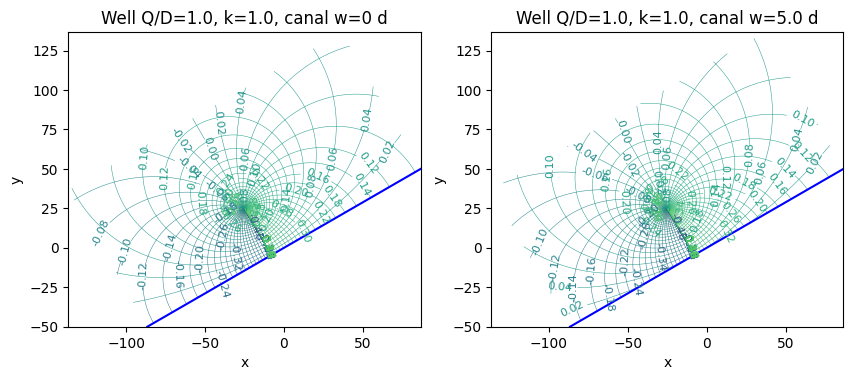

In [129]:
z0 = -25. + 1j * 25.
z1 = 0 + 1j *  0.
slope_deg =    30.
Q_D, k, w = 1., 1., 5.
ws = (0, 5.)
L = 100
N = 200

# --- make a grid fitted above the linesink
tr = Affine2D().rotate_deg(slope_deg).translate(z1.real, z1.imag)
Z = make_complex(np.linspace(-L, L, 2 * N + 1), np.linspace(L, 0, N + 1))
Z = trans_z(Z, tr)

levels = np.linspace(-1, 1, 101)

fig, axs = plt.subplots(1, 2, figsize=(10, 7))
for (ax, w) in zip(axs, ws):
    ax.set(title=f"Well Q/D={Q_D}, k={k}, canal w={w} d", xlabel='x', ylabel='y')
    print(f"Q/D={Q_D}, w={w}, k={k}")
    
    Om = b316_41(Z, z0=z0, z1=z1, slope_deg=slope_deg, Q_D=Q_D, k=k, w=w, alpha_deg=180, rwell=0.25)

    Cs1 = ax.contour(Z.real, Z.imag, Om.real, levels=levels, linewidths=0.35)
    Cs2 = ax.contour(Z.real, Z.imag, Om.imag, levels=levels, linewidths=0.35)
    ax.clabel(Cs1, Cs1.levels, fmt="%.2f", fontsize=8)
    ax.clabel(Cs2, Cs2.levels, fmt="%.2f", fontsize=8)
    
    # --- the canal
    L = 50
    lsink = np.array([z1 - L * np.exp(1j * slope_deg * np.pi / 180),
                      z1 + L * np.exp(1j * slope_deg * np.pi / 180)])
    
    # ax.plot(lsink.real, lsink.imag, 'ro-')
    ax.plot(Z[-1].real, Z[-1].imag, 'b')
    
    # ax.set_xlim(-50, 50)
    # ax.set_ylim(-5, 50)
    ax.set_aspect(1.)


# Now with anisotropy

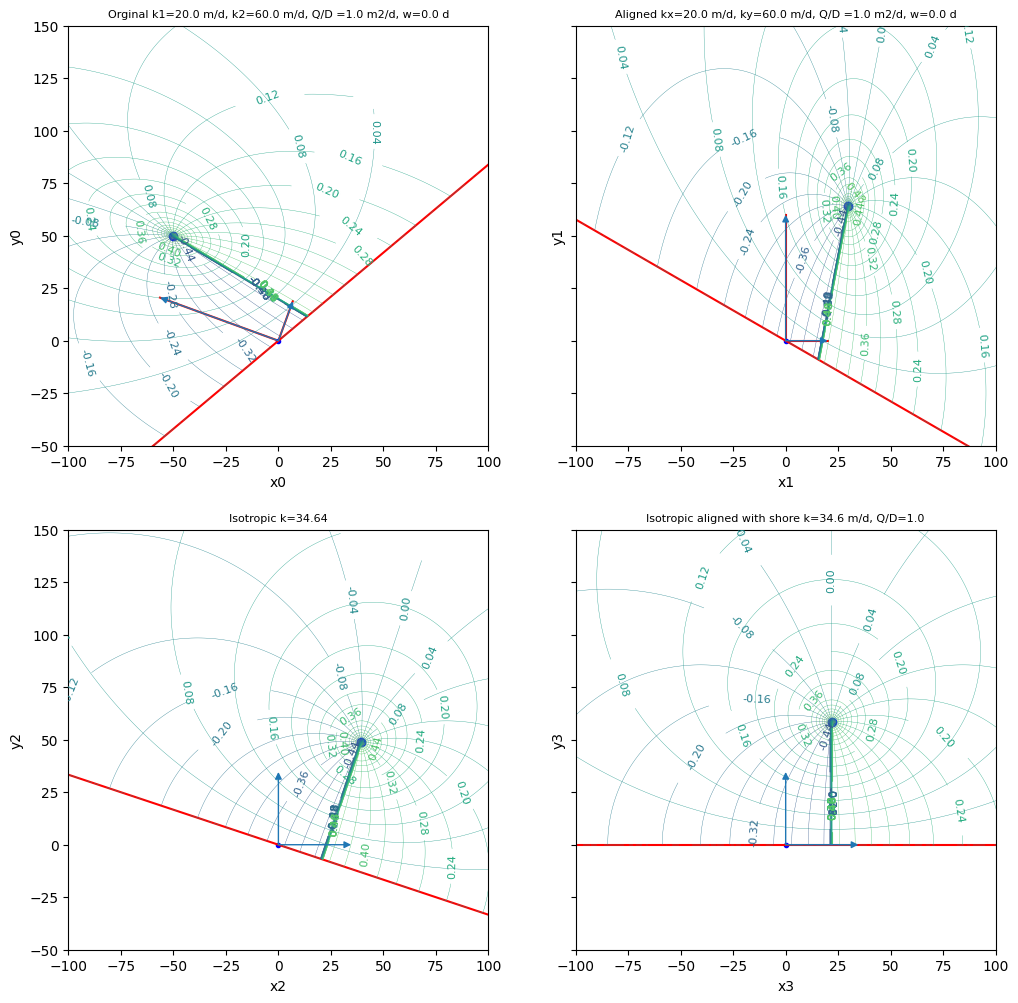

In [170]:
# --- spatial data
well = (-50, 50)
point = (0, 0)

z0_aniso = well[0]  + 1j * well[1], 
z1_aniso = point[0] + 1j * point[1]
shore_slope_deg = 40.
theta_aniso_deg = 70

# --- Shore line (use length L) in the original anisotropic medium
L = 200.
shore_vec_aniso = L * np.exp(1j * np.pi * shore_slope_deg / 180.)
shore_line_aniso = np.array([z1_aniso - shore_vec_aniso, z1_aniso + shore_vec_aniso])

# --- aquifer data and extraction
Q_D, w = 1., 0.
# --- conductivities along main anisotropy axes
k1, k2 = 20., 60.
k = np.sqrt(k1 * k2)

# --- Determine begin and end coordinates for arrows indicatting k in anisotropi medium
k1_ = xy2z(Affine2D().rotate_deg(theta_aniso_deg).transform(z2xy(     k1)))
k2_ = xy2z(Affine2D().rotate_deg(theta_aniso_deg).transform(z2xy(1j * k2)))

# --- scaling factors to isotropic
sx, sy = np.sqrt(k / k1), np.sqrt(k / k2)

# --- Prepare: make a grid perpendicular to the shore in the origonal anisotropic medium
tr_to_aniso = Affine2D().rotate_deg(slope_deg).translate(z1_base.real, z1_base.imag)

# --- Transforms
# --- First null tranform allowing unified approach in all maps
tr0 = Affine2D()

# --- Second, align with k1 and k2 axes (rotage -theta_aniso_deg)
rotate_aniso = Affine2D().rotate_deg(-theta_aniso_deg) 
tr1 = rotate_aniso

# --- Third, scale to make medium isotropic
scale =  Affine2D().scale(sx, sy)
tr2 = tr1 + scale

z1tr2 = trans_z(z1_aniso, tr2)

# --- Translate z1 to origin and rotate to align shore with final x-axes
shore_angle_deg_tr2 = np.angle(trans_z(shore_vec_aniso, tr2))

translate_shore  = Affine2D().translate(-z1tr2.real, -z1tr2.imag) 
rotate_shore     = Affine2D().rotate(-shore_angle_deg_tr2)


tr3 = tr2 + translate_shore + rotate_shore

trs = [tr0, tr1, tr2, tr3]

# --- Generate Z points in tr3 isotropic medium
L, N = 150., 100
Ztr3 = make_complex(np.linspace(-L, L, 2 * N + 1), np.linspace(L, 0, N + 1))

z0tr3 = trans_z(z0_aniso, tr3)
z1tr3 = trans_z(z0_aniso, tr3)

levels = np.linspace(-1, 1, 51)

titles = [f"Orginal k1={k1} m/d, k2={k2} m/d, Q/D ={Q_D} m2/d, w={w} d",
          f"Aligned kx={k1} m/d, ky={k2} m/d, Q/D ={Q_D} m2/d, w={w} d",
          f"Isotropic k={k:.2f}",
          f"Isotropic aligned with shore k={k:.1f} m/d, Q/D={Q_D}"]

# --- here we go
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
for ia, (ax, tr, title) in enumerate(zip(axs.ravel(), trs, titles)):
    ax.set(xlabel=f'x{ia}', ylabel=f'y{ia}')
    ax.set_title(title, fontsize=8)
    
    # --- The axes arrows without ax.transData
    if tr in trs[-2:]:        
        arrow(z1_aniso, z1_aniso +      k, ax=ax, transform=None, color="C0", lw=1)
        arrow(z1_aniso, z1_aniso + 1j * k, ax=ax, transform=None, color="C0", lw=1)
    else:
        plotz(np.array([z1_aniso, z1_aniso + trans_z(k1_, tr)], dtype=np.complex128), 'r', ax=ax)
        plotz(np.array([z1_aniso, z1_aniso + trans_z(k2_, tr)]), 'r', ax=ax)
        
        arrow(z1_aniso, z1_aniso + trans_z(k1_, tr), ax=ax, transform=None, color="C0", lw=1)
        arrow(z1_aniso, z1_aniso + trans_z(k2_, tr), ax=ax, transform=None, color="C0", lw=1)
    
    # --- plot well
    z0 = trans_z(z0_aniso, tr)
    plotz(z0, 'bo', ax=ax)
    
    # --- plot z1
    z1 = trans_z(z1_aniso, tr)
    plotz(z1, 'b.', ax=ax)
    
    # --- Plot linesink
    shore_line = trans_z(shore_line_aniso, tr)
    plotz(shore_line, 'r', ax=ax)
        
    ax.set_aspect(1)
    
    
# --- Handling the isotropic situation
z0tr3 = trans_z(z0_aniso, tr3)
z1tr3 = trans_z(z1_aniso, tr3)
Om = b316_41(Ztr3, z0=z0tr3, z1=z1tr3, slope_deg=0, Q_D=Q_D, k=k, w=w, alpha_deg=180, rwell=0.25)


# --- Back transformations
tr0 =  Affine2D()
tr1 = tr0 + rotate_shore.inverted() + translate_shore.inverted()
tr2 = tr1 + scale.inverted()
tr3 = tr2 + rotate_aniso.inverted()
trs = [tr0, tr1, tr2, tr3]

for ax, tr in zip(axs.ravel()[::-1], trs):
    Z = trans_z(Ztr3, tr)
    Cs1 = ax.contour(Z.real, Z.imag, Om.real, levels=levels, linewidths=0.25)
    Cs2 = ax.contour(Z.real, Z.imag, Om.imag, levels=levels, linewidths=0.25)
    ax.clabel(Cs1, Cs1.levels, fmt="%.2f", fontsize=8)
    ax.clabel(Cs2, Cs2.levels, fmt="%.2f", fontsize=8)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-50, 150)
    ax.set_aspect(1.)
    
fig.savefig(os.path.join(os.getcwd(), '../images/aniso_canal_with_resistance.png'))
